# Профильное задание ML-инженер
Выполнила: Раимова Алина

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# pip install torch

## Подготовка данных

Загрузим данные

In [3]:
train_data = pd.read_csv('train_spam.csv')

In [4]:
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Заменим целевую переменную: ham = 0, spam = 1. Решаем задачу бинарной классификации с текстовыми данными

In [5]:
train_data['target'] = train_data['text_type'].replace({'spam': 1, 'ham': 0})

In [6]:
train_data.head()

,text_type,text,target
0,ham,make sure alex knows his birthday is over in f...,0
1,ham,a resume for john lavorato thanks vince i will...,0
2,spam,plzz visit my website moviesgodml to get all m...,1
3,spam,urgent your mobile number has been awarded wit...,1
4,ham,overview of hr associates analyst project per ...,0


Посмотрим на распределение классов в выборке. Как видим, классы несбалансированы, число "неспама" больше чем в 2 раза

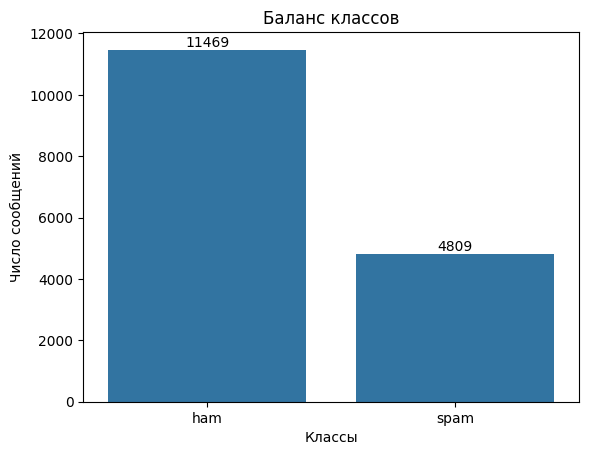

In [7]:
ax = sns.barplot(train_data['text_type'].value_counts())
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title='Баланс классов', xlabel='Классы', ylabel='Число сообщений');

Проверим данные на пустые значения. Таких нет

In [8]:
train_data['text'].isna().sum()

0

### Токенизация и чистка текста

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [10]:
# nltk.download('punkt', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [12]:
train_data['processed_text'] = train_data['text'].apply(preprocess)

### Облака слов

In [13]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

#### Облако слов для класса "Спам"

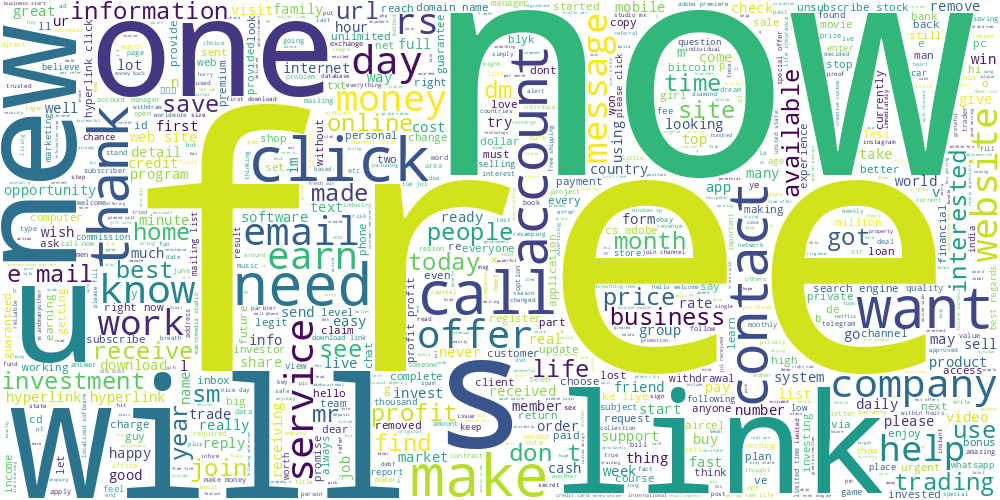

In [14]:
draw_wordcloud(train_data[train_data['target'] == 1].text)

Можно заметить характерные для спама слова: free, now, link, earn, click

#### Облако слов для класса "Неспам"

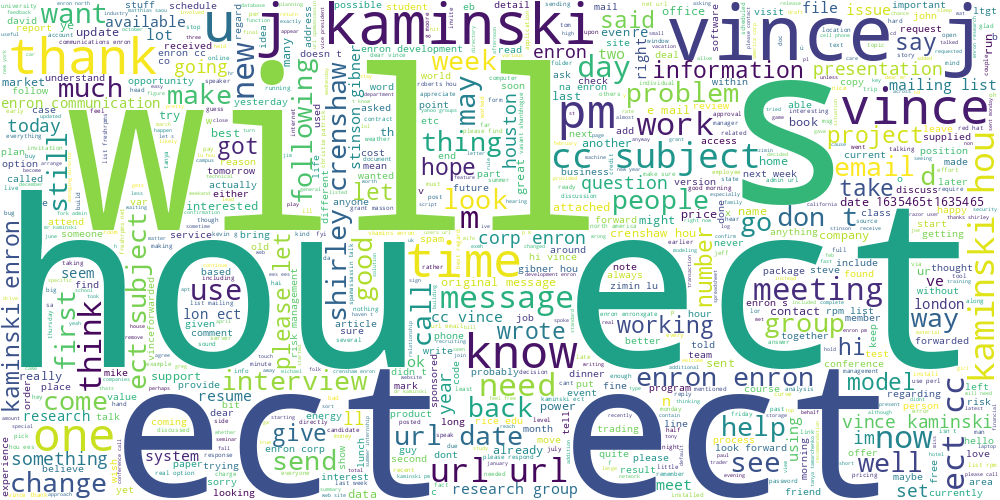

In [15]:
draw_wordcloud(train_data[train_data['target'] == 0].text)

## Сравнение моделей

Я буду обучать несколько моделей и по метрике ROC-AUC выберу наилучшую:
- Наивный классификатор Байеса
- Логистическая регрессия
- Метод опорных векторов
- Адаптивный бустинг
- CatBoost
- простая нейронная сеть

In [16]:
# Создадим датасет, в котором будем хранить скоры моделей, а также время их обучения
results = pd.DataFrame(columns=['model', 'roc_auc', 'time'])

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from time import time

Применим к тексту `TF-IDF` метод и стандантизируем `MaxAbsScaler`

In [18]:
tfidf_vec = TfidfVectorizer()
scaler1 = MaxAbsScaler()

In [19]:
X = train_data['processed_text']
y = train_data['target'].values

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
X_train = tfidf_vec.fit_transform(X_train)
X_val = tfidf_vec.transform(X_val)

X_train = scaler1.fit_transform(X_train)
X_val = scaler1.transform(X_val)

Сначала посмотрим на работу самого простого алгоритма - наивного классификатора Байеса

In [22]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

start = time()
nb.fit(X_train.toarray(), y_train)
end = time()

y_pred = nb.predict_proba(X_val.toarray())[:, 1]

new_row = {
    'model': 'GaussianNB',
    'roc_auc': roc_auc_score(y_val, y_pred),
    'time': round(end - start, 2)
}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

По must have обучим логистичекую регресию

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

start = time()
logreg.fit(X_train, y_train)
end = time()

y_pred = logreg.predict_proba(X_val)[:, 1]

new_row = {
    'model': 'LogisticRegression',
    'roc_auc': roc_auc_score(y_val, y_pred),
    'time': round(end - start, 2)
}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

Опробуем метод опорных векторов

In [24]:
from sklearn.svm import SVC

svm_model = SVC(probability=True)

start = time()
svm_model.fit(X_train, y_train)
end = time()

y_pred = svm_model.predict_proba(X_val)[:, 1]

new_row = {
    'model': 'SVC',
    'roc_auc': roc_auc_score(y_val, y_pred),
    'time': round(end - start, 2)
}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

Без деревьев никуда, поэтому попробуем ансамбливый метод - адаптивный бустинг

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42)

start = time()
ada_model.fit(X_train, y_train)
end = time()

y_pred = ada_model.predict_proba(X_val)[:, 1]

new_row = {
    'model': 'AdaBoostClassifier',
    'roc_auc': roc_auc_score(y_val, y_pred),
    'time': round(end - start, 2)
}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

Также посмотрим на модель `CatBoost` и обучим ее на мешке слов, использовав `CountVectorizer`

In [26]:
vec = CountVectorizer()
scaler2 = MaxAbsScaler()

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [28]:
X_train = vec.fit_transform(X_train)
X_val = vec.transform(X_val)

X_train = scaler2.fit_transform(X_train)
X_val = scaler2.transform(X_val)

In [29]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=300, depth=6, verbose=False)

start = time()
catboost_model.fit(X_train, y_train)
end = time()

y_pred = catboost_model.predict_proba(X_val)[:, 1]

new_row = {
    'model': 'CatBoostClassifier',
    'roc_auc': roc_auc_score(y_val, y_pred),
    'time': round(end - start, 2)
}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

TBB Warning: The number of workers is currently limited to 3. The request for 43 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Ну и попробуем нейронку забабахать. По структуре будет очень простой

In [30]:
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Embedding, LSTM, Dense

In [31]:
model_nn = models.Sequential()
model_nn.add(layers.Dense(64, activation='relu'))
model_nn.add(layers.BatchNormalization())
model_nn.add(layers.Dropout(0.2))
model_nn.add(layers.Dense(64, activation='relu'))
model_nn.add(layers.BatchNormalization())
model_nn.add(layers.Dropout(0.2))
model_nn.add(layers.Dense(1, activation='sigmoid'))

2024-05-03 21:40:02.380336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-05-03 21:40:02.380393: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-03 21:40:02.380975: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
start = time()
history = model_nn.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_val, y_val))
end = time()

Epoch 1/20
23/23 [==============================] - 2s 23ms/step - loss: 0.4002 - accuracy: 0.8248 - val_loss: 0.6064 - val_accuracy: 0.7355
Epoch 2/20
23/23 [==============================] - 0s 15ms/step - loss: 0.1170 - accuracy: 0.9718 - val_loss: 0.5463 - val_accuracy: 0.7596
Epoch 3/20
23/23 [==============================] - 0s 14ms/step - loss: 0.0502 - accuracy: 0.9880 - val_loss: 0.5001 - val_accuracy: 0.7695
Epoch 4/20
23/23 [==============================] - 0s 15ms/step - loss: 0.0326 - accuracy: 0.9926 - val_loss: 0.4632 - val_accuracy: 0.7641
Epoch 5/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0251 - accuracy: 0.9932 - val_loss: 0.4250 - val_accuracy: 0.7772
Epoch 6/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0186 - accuracy: 0.9957 - val_loss: 0.4089 - val_accuracy: 0.7799
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.3809 - val_accuracy: 0.8096
Epoch 8/20
23

In [34]:
def fit_line(history_data):
    # построение графика потери на этапах проверки и обучения
    loss_values = history_data['loss']
    val_loss_values = history_data['val_loss']
    epochs = range(1, len(history_data['accuracy']) + 1)

    # построение графика потери на этапах проверки и обучения
    loss_values = history_data['loss']
    val_loss_values = history_data['val_loss']
    epochs = range(1, len(history_data['accuracy'])+1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].plot(epochs, loss_values, 'bo', label = 'Потери на этапе обучения')
    axes[0].plot(epochs, val_loss_values, 'b', label = 'Потери на этапе проверки')
    axes[0].set_title('Потери на этапах обучения и проверки')
    axes[0].set_xlabel('Эпохи')
    axes[0].set_ylabel('Потери')
    axes[0].legend()
    # axes[0].show()

    # построение графика точности на этапах обучения и проверки
    acc_values = history_data['accuracy']
    val_acc_values = history_data['val_accuracy']
    axes[1].plot(epochs, acc_values, 'bo', label = 'Точность на этапе обучения')
    axes[1].plot(epochs, val_acc_values, 'b', label = 'Точность на этапе проверки')
    axes[1].set_title('Точность на этапах обучения и проверки')
    axes[1].set_xlabel('Эпохи')
    axes[1].set_ylabel('Точность')
    axes[1].legend()
    
    plt.show()

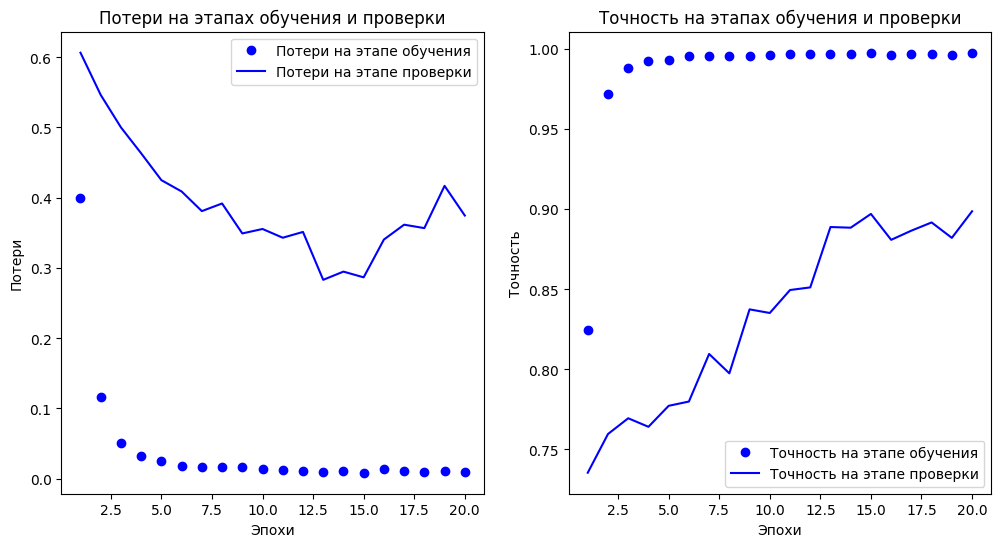

In [35]:
fit_line(history.history)

Судя по графику, модель начала переобучаться, но посмотрим, что скажут нам числа

In [36]:
y_pred = model_nn.predict(X_val)

new_row = {
    'model': 'NNmodel',
    'roc_auc': roc_auc_score(y_val, y_pred),
    'time': round(end - start, 2)
}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

In [37]:
results

,model,roc_auc,time
0,GaussianNB,0.767845,6.67
1,LogisticRegression,0.980580,1.00
2,SVC,0.959868,147.52
3,AdaBoostClassifier,0.949049,9.54
4,CatBoostClassifier,0.968070,20.08
5,NNmodel,0.963807,8.64


## Выводы
Судя по таблице лучшее качество показала логистическая регрессия причем и с наименьшим временем обучения. Так что в качестве инференса возьмем именно ее. Про остальные моедли, в принципе все модели показали себя на уровне, отстав всего на несколько сотых, но вот классификатор Байеса остался в аутсайдерах.

## Предсказание на тесте

In [38]:
test_data = pd.read_csv('test_spam.csv')

In [39]:
test_data.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [40]:
test_data['processed_text'] = test_data['text'].apply(preprocess)
X_test = tfidf_vec.transform(test_data['processed_text'])
X_test = scaler1.transform(X_test)

y_pred = logreg.predict_proba(X_test)[:, 1]

In [41]:
test_data['score'] = y_pred

In [42]:
test_data.head()

,text,processed_text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,j jim whitehead ejw cse ucsc edu writes j open...,0.012295
1,original message from bitbitch magnesium net p...,original message bitbitch magnesium net people...,0.039541
2,java for managers vince durasoft who just taug...,java manager vince durasoft taught java class ...,0.024706
3,there is a youtuber name saiman says,youtuber name saiman,0.120921
4,underpriced issue with high return on equity t...,underpriced issue high return equity oil gas a...,0.801740


In [45]:
test_data[['text', 'score']].to_csv('predictions.csv', index=False)